# LSPI on LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]

# Sample collection
max_discrete_state = parameters["max_discrete_state"]
n_discrete_states = parameters["n_discrete_states"]
max_discrete_action = parameters["max_discrete_action"]
n_discrete_actions = parameters["n_discrete_actions"]
n_samples = n_discrete_states * n_discrete_actions

# Q function
action_range_on_max = parameters["action_range_on_max"]
n_actions_on_max = parameters["n_actions_on_max"]

# Trainings
max_bellman_iterations = parameters["max_bellman_iterations"]

# Search for an unused seed
max_used_seed = 0
if not os.path.exists("figures/data/LSPI/"):
    os.makedirs("figures/data/LSPI/")
for file in os.listdir("figures/data/LSPI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
env_key = jax.random.PRNGKey(env_seed)
seed = max_used_seed + 1
key = jax.random.PRNGKey(seed)
initial_policy_key, dummy_q_network_key, _, _ = jax.random.split(key, 4) # 4 keys are generated to be coherent with the other trainings

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 0.7204725742340088s + -0.5264108180999756a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.13297832012176514s² + -0.8039400577545166a² + 0.2581009864807129sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, absorbing, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

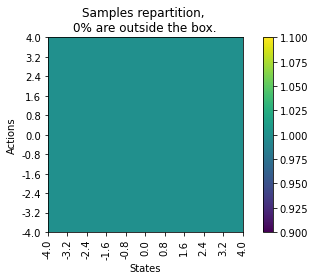

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, discrete_states_boxes, discrete_actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Train LSPI

In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import LQRQ

data_loader_samples = SampleDataLoader(replay_buffer, 1, None)
q = LQRQ(
    state_dim=1,
    action_dim=1,
    n_actions_on_max=n_actions_on_max,
    action_range_on_max=action_range_on_max,
    network_key=dummy_q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=None,
    zero_initializer=True,
)

weights = np.zeros((max_bellman_iterations + 1, q.weights_dimension))

weights[0] = q.to_weights(q.params)
print(weights[0])

for bellman_iteration in tqdm(range(1, max_bellman_iterations + 1)):
    A = np.zeros((q.weights_dimension, q.weights_dimension))
    b = np.zeros(q.weights_dimension)

    for batch_samples in data_loader_samples:
        state = batch_samples["state"][0, 0]; action = batch_samples["action"][0, 0]
        reward = batch_samples["reward"][0, 0]; next_state = batch_samples["next_state"][0, 0]
        next_action = q.discrete_actions_on_max[q(q.params, next_state, q.discrete_actions_on_max).argmax()][0]

        if len(np.unique(q(q.params, next_state, q.discrete_actions_on_max))) == 1:
            initial_policy_key, key = jax.random.split(initial_policy_key)
            next_action = jax.random.choice(key, q.discrete_actions_on_max.flatten())

        phi = np.zeros((q.weights_dimension, 1))
        phi[0, 0] = state ** 2; phi[1, 0] = 2 * state * action; phi[2, 0] = action ** 2
        next_phi = np.zeros((q.weights_dimension, 1))
        next_phi[0, 0] = next_state ** 2; next_phi[1, 0] = 2 * next_state * next_action; next_phi[2, 0] = next_action ** 2

        A += phi @ (phi - next_phi).T
        b += reward * phi.reshape(q.weights_dimension)

    q_weigth_i = np.linalg.solve(A, b)
    q.params = q.to_params(q_weigth_i)
    
    weights[bellman_iteration] = q_weigth_i
    
    print(q_weigth_i)

print("Optimal weights")
print(env.optimal_weights)

[0. 0. 0.]


  0%|          | 0/4 [00:00<?, ?it/s]

[ 2.04973269 -0.53159587  1.18608834]
[0.80967368 0.60968212 0.57451562]
[ 1.0697097  -0.12070327  0.26497472]
[0.80967368 0.60968212 0.57451562]
Optimal weights
[-0.22707027  0.19779846 -0.8541705 ]


## Save data

In [6]:
np.save(f"figures/data/LSPI/{max_bellman_iterations}_W_{seed}.npy", weights)
np.save(f"figures/data/LSPI/{max_bellman_iterations}_Pi_{seed}.npy", env.greedy_V(weights))

## Visualize

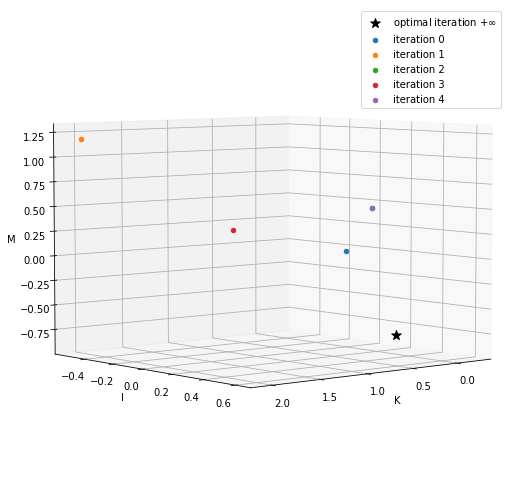

In [7]:
from pbo.utils.lqr_weights_viewer import visualize


visualize(weights, env.optimal_weights)